In [12]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [13]:
# Defines
file_path = "..\\..\\Datasets\\Data.xlsx"
data_title = "data_Flex_raw_data"


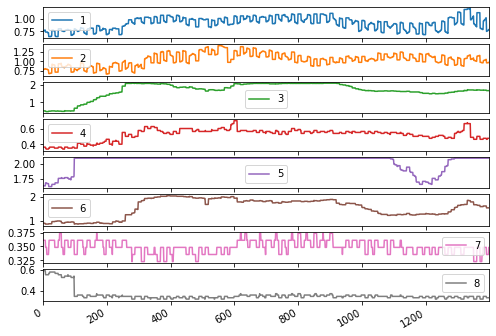

In [14]:
# Load data
table_of_contents = pd.read_excel(file_path, sheet_name=0, header=None)
sheet_index = table_of_contents[table_of_contents[0] == data_title][0].index[0]
sheet_data = pd.read_excel(file_path, sheet_name=sheet_index + 1, header=None)
sheet_data.columns = ['1' ,'2', '3', '4', '5', '6', '7', '8', 'N/A_1', 'N/A_2', 'angle', 'time', 'session']

features_considered = ['1' ,'2', '3', '4', '5', '6', '7', '8']
features = sheet_data[features_considered]
# features.index = sheet_data['time'] # If I index time, then we have floats as indexes. One row already represents one time point

features.plot(subplots=True)

ground_truth = pd.DataFrame(sheet_data['angle'])
#ground_truth.index = sheet_data['time']

#data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
#data_std = dataset[:TRAIN_SPLIT].std(axis=0)
#dataset = (dataset-data_mean)/data_std
# SEEMS UNECESSARY, AS WE NORMALIZE ON THE SENSOR

#pd.DataFrame(dataset).plot(subplots=True)
# HOW MUCH DIFFERENCE IS THERE?


In [15]:
# x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0, TRAIN_SPLIT, past_history,
#                                                   future_target, STEP, single_step=True)
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False, print_index=False):
  data = []
  labels = []

  start_index = start_index + history_size # such that we always have history_size (100) observations to base our predictions on
  if end_index is None:
    end_index = len(dataset) - target_size # such that we never predict based on the last future_target (10) measurements

  if print_index: print("start")

  for i in range(start_index, end_index): # start 100, end 790. 
      # TODO: It actually goes to 800 (when end_index is not None), meaning that our last 10 predictions cannot be verified with our training set. This is a problem
    if print_index: print("A", i,)
    indices = range(i-history_size, i, step) # range(0, 100) step size of 1          --- our sliding window
    #print("B", i,)
    data.append(dataset[indices]) # append new array that contains all values within our sliding window
    #print("C", i,)
    # ONE PROBLEM KINDA? Step size makes no sense. Doesn't feel like there's any point to it. 

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])
    #print("D", i,)

  return np.array(data), np.array(labels)

In [16]:
STEP = 1
past_history = 20 #100
future_target = 5 #10            # setting this to 0 would make sense
# Aggregates STEP predictions, looks at a total of PASTHISTORY observations, 
# predicts the observation at FUTURETARGET observations in the future

TRAIN_SPLIT = 800


########## TODO WHAT DO THESE MEAN?
EVALUATION_INTERVAL = 200
EPOCHS = 10
VAL_STEPS = 50

dataset = features.values
ground_truth2 = ground_truth.values
#penis = ground_truth2[:, 1]

In [17]:

x_train_single, y_train_single = multivariate_data(dataset, ground_truth2, 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=False, print_index = False)

print ('Single window of past history : {}'.format(x_train_single[0].shape))
print(len(x_train_single), len(y_train_single))
print(x_train_single.shape)

Single window of past history : (20, 8)
780 780
(780, 20, 8)


In [18]:
x_val_single, y_val_single = multivariate_data(dataset, ground_truth2, TRAIN_SPLIT, 
                                               None, past_history,
                                               future_target, STEP,
                                               single_step=False, print_index = False)

In [19]:
#BATCH_SIZE = 10
BATCH_SIZE = 1
#BUFFER_SIZE = 100


# TODO: This function takes wayy too fucking long to execute and doesn't tell me how far it is. 
#  Better solution is to use from_generator? Such that it yields results as it needs them?
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
#train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()


val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))

#val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

# Here we apply batching and shuffling. But WHY? 

In [20]:
print(x_train_single.shape)
single_step_model = tf.keras.models.Sequential()
#single_step_model.add(tf.keras.layers.LSTM(32, batch_input_shape=(BATCH_SIZE, x_train_single.shape[1], x_train_single.shape[2]), return_sequences = False)) # input_shape=x_train_single.shape[-2:]
single_step_model.add(tf.keras.layers.LSTM(32, input_shape=x_train_single.shape[-2:], return_sequences = False))
single_step_model.add(tf.keras.layers.Dense(future_target))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')
single_step_model.summary()

(780, 20, 8)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                5248      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 165       
Total params: 5,413
Trainable params: 5,413
Non-trainable params: 0
_________________________________________________________________


In [21]:
#for x, y in val_data_single.take(1):
#  print (single_step_model.predict(x).shape)


In [22]:
EPOCHS = 5
EVALUATION_INTERVAL = int(len(x_train_single) / BATCH_SIZE)
VAL_STEPS = int(len(x_val_single) / BATCH_SIZE)

single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=VAL_STEPS
                                            )



Train for 780 steps, validate for 573 steps
Epoch 1/5
  1/780 [..............................] - ETA: 7s

ValueError: Error when checking input: expected lstm_1_input to have 3 dimensions, but got array with shape (20, 8)